In [6]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')


# import script that has formation channel classification functions:
from PostProcessingScripts import * 


from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import astropy
import seaborn as sns
from seaborn_utility import cmap_from_colour


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

from KDEpy import FFTKDE
from scipy.stats import norm

colors = ['#1f77b4', '#ff7f0e', 'gray']
colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7), adjust_lightness(color=colors[2], amount=1.7)]



In [ ]:
## 

In [18]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    bins = 10000
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
        M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
        Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
        MassRatioZAMS = M2ZAMS / M1ZAMS 

        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

    
        var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                   'Chirpmass':Chirpmass, 'M1':M1, 'M2':M2, 'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}
        
        
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
        
            ls_ = '-'
            Highlight = False
            if ((mssfr in ['123']) & (BPSmodelName in ['K'])):
                ls_ = ':'
                Highlight = True
            elif  ((mssfr in ['312']) & (BPSmodelName in ['T'])):
                ls_ = '--'
                Highlight = True
            elif ((mssfr in ['231']) & (BPSmodelName in ['O'])):
                ls_ = '-.'
                Highlight = True
                
            
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            
            if Highlight==True:
#                 axe.hist(var_dict[xvar],           bins=bins, weights=w,           cumulative=True, density=True, color=colors[2], histtype='step', lw=4.5, zorder=16, alpha=1,  ls=ls_)
                axe.hist(var_dict[xvar][mask_MRR], bins=bins, weights=w[mask_MRR], cumulative=True, density=True, color=colors[1], histtype='step', lw=4.5, zorder=110, alpha=1, ls=ls_)
                axe.hist(var_dict[xvar][~mask_MRR], bins=bins, weights=w[~mask_MRR], cumulative=True, density=True, color=colors[0], histtype='step', lw=4.5, zorder=110, alpha=1, ls=ls_)

            else:
#                 axe.hist(var_dict[xvar],           bins=bins, weights=w,           cumulative=True, density=True, color=colors_lighter[2], histtype='step', lw=4.5, zorder=6, alpha=1,  ls=ls_)
                axe.hist(var_dict[xvar][mask_MRR], bins=bins, weights=w[mask_MRR], cumulative=True, density=True, color=colors_lighter[1], histtype='step', lw=4.5, zorder=10, alpha=1, ls=ls_)
                axe.hist(var_dict[xvar][~mask_MRR], bins=bins, weights=w[~mask_MRR], cumulative=True, density=True, color=colors_lighter[0], histtype='step', lw=4.5, zorder=10, alpha=1, ls=ls_)
  
 
    # BEAUTIFY: 

    ylabel='CDF'

    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
    if (BPSmodelName=='A'):              
        if (xvar=='MassRatioZAMS'):

            xx = [-100, -50]
#             axe.plot(xx, np.ones_like(xx)*-100,  color=colors_lighter[2], zorder=2, lw=16, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
            axe.plot(xx, np.ones_like(xx)*-100,  color=colors_lighter[1], zorder=2, lw=16, alpha=1, ls='-', label = r'$\textbf{MRR}$')
            axe.plot(xx, np.ones_like(xx)*-100,  color=colors_lighter[0], zorder=2, lw=16, alpha=1, ls='-', label = r'$\textbf{non-MRR}$')
        #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
            ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)

            # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
            xx_q = np.linspace(0,1, 100)
            yy_q = np.linspace(0,1, 100)
            ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
#             ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)

        elif xvar=='separationZAMS':        
            # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
            yy_q = np.linspace(0,1, 100)
            xx_q = np.logspace(-2,3, 100)
            ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
#             ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)

        elif xvar=='M1ZAMS':        
            # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
            xx_q = np.linspace(5,150, 100)
            yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
            yy_q = np.cumsum(yy_q)
            ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
#             ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)

        

    axe.grid(True)
    if xvar=='M1ZAMS':
        _ == layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
    else:
        _ == layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
#         axe.set_yticks([])
        axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS':
        
        ax.set_xscale('log')
    


    return



now running model  A  for x =  M1ZAMS
now running model  A  for x =  MassRatioZAMS
now running model  A  for x =  separationZAMS
now running model  B  for x =  M1ZAMS
now running model  B  for x =  MassRatioZAMS
now running model  B  for x =  separationZAMS
now running model  C  for x =  M1ZAMS
now running model  C  for x =  MassRatioZAMS
now running model  C  for x =  separationZAMS
now running model  D  for x =  M1ZAMS
now running model  D  for x =  MassRatioZAMS
now running model  D  for x =  separationZAMS
now running model  E  for x =  M1ZAMS
now running model  E  for x =  MassRatioZAMS
now running model  E  for x =  separationZAMS
now running model  F  for x =  M1ZAMS
now running model  F  for x =  MassRatioZAMS
now running model  F  for x =  separationZAMS
now running model  G  for x =  M1ZAMS
now running model  G  for x =  MassRatioZAMS
now running model  G  for x =  separationZAMS
now running model  H  for x =  M1ZAMS
now running model  H  for x =  MassRatioZAMS
now running mo

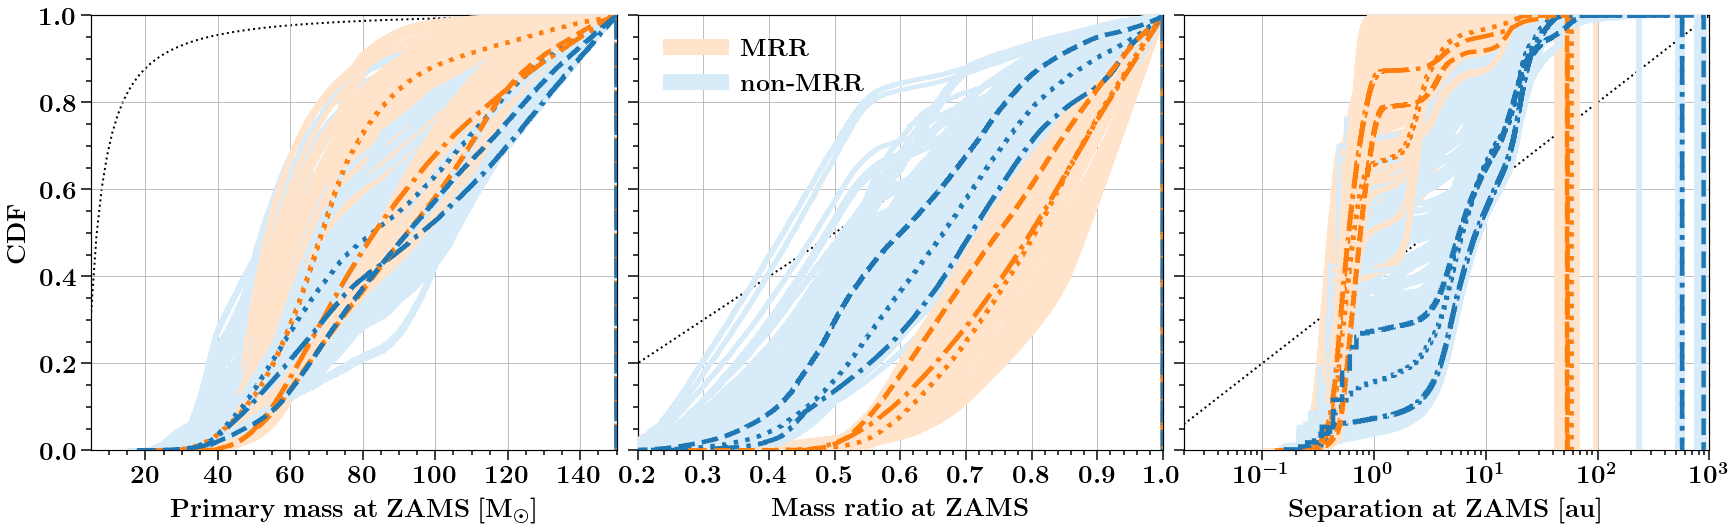

In [19]:
f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))

for BPS in BPSnameslist[:]:
# for BPS in [BPSnameslist[0]]:    
    
    # plot M1ZAMS on the left panel
    xvar='M1ZAMS'    
    plotHist_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=5, xvar_maxx=150, DCOtype='BBH' ,label_x=r'$\textbf{Primary} \ \textbf{mass} \  \textbf{at} \ \textbf{ZAMS} \ [\rm{M}_{\odot}] $')

    # plot Mass Ratio ZAMS on the left panel
    xvar='MassRatioZAMS'    
    plotHist_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio}  \ \textbf{at} \ \textbf{ZAMS} $')

    xvar='separationZAMS'    
    plotHist_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.02, xvar_maxx=1000, DCOtype='BBH' ,label_x=r'$\textbf{Separation} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')
    
plt.subplots_adjust(wspace=0.04, hspace=0)#2)


plt.savefig('./CDF_models_multiPanel_ZAMS.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
plt.show()



# Extra Figures 

### FINAL PROPERTIES 

In [ ]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
                
        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

        if xvar in ['MassRatioZAMS', 'separationZAMS',  'TotalMassZAMS' , 'M1ZAMS', 'M2ZAMS', 'separationZAMS'  ]:
            M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
            M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
            separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
            Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
            MassRatioZAMS = M2ZAMS / M1ZAMS             
            var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                         'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}   
            
            
        elif xvar in ['Chirp_mass', 'MBH_from_ZAMSM1', 'MBH_from_ZAMSM2',  'M1LVK', 'M2LVK', 'qLVK', 'Total_mass', \
                     'Effective_spin']:
            
            M1BH = fdata['doubleCompactObjects']['M1'][...].squeeze()
            M2BH = fdata['doubleCompactObjects']['M2'][...].squeeze()
            # M1 will be the most massive, M2 the least massive compact object. 
            M1LVK, M2LVK = obtainM1BHandM2BHassymetric(m1=M1BH, m2=M2BH) 
            Chirpmass = chirpmass(M1LVK, M2LVK)
            MassRatioLVK = M2LVK/M1LVK
            

            spin = COspin(data_path=path)  # set class 
            spin.setCOMPASData() # reads in the COMPAS DCO parameters 
            spinMZAMS1, spinMZAMS2  = spin.BaveraSpin()
            chi_effective = (spinMZAMS1*M1BH) + (spinMZAMS2*M2BH)
            chi_effective = chi_effective/(M1BH+M2BH)
            del spinMZAMS1
            del spinMZAMS2
            del spin            
            
            var_dict = {'Chirp_mass':Chirpmass, 'MBH_from_ZAMSM1':M1BH, 'MBH_from_ZAMSM2':M2BH,\
                        'M1LVK':M1LVK, 'M2LVK':M2LVK, 'qLVK':MassRatioLVK, 'Total_mass':(M1LVK+M2LVK),\
                       'Effective_spin':chi_effective}
            del M1BH
            del M2BH
            
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            # make CDF of all BBH systems
            axe.hist(var_dict[xvar], bins=len(var_dict[xvar]), weights=w, cumulative=True, density=True, color='k', histtype='step', lw=4, zorder=6, alpha=1, ls='-')
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][mask_MRR], bins=len(var_dict[xvar][mask_MRR]), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=5, zorder=10, alpha=1, ls='--')
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][~mask_MRR], bins=len(var_dict[xvar][~mask_MRR]), weights=w[~mask_MRR], cumulative=True, density=True, color=c_BBH, histtype='step', lw=3, zorder=10, alpha=1, ls='--')

 
    del fdata
    del var_dict

    # BEAUTIFY:     
    ylabel='CDF'
    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color='k', zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=3, lw=4.5, alpha=1, ls=':', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=3, lw=4.5, alpha=1, ls=':', label = r'$\textbf{not} \  \textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
     
    elif xvar=='M1LVK':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color='k', zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} $')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{not} \  \textbf{MRR} $')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(3, 0.6,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      

    
    axe.grid(True)
    _ = layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 

    

    
    if xvar=='separationZAMS' :
        ax.set_xscale('log')
    elif xvar=='Effective_spin':
#         ax.set_yscale('log') 
        ax.set_ylim(0.5, 1)
        ax.set_xlim(0., .5)
        print()
    

    

    return

In [ ]:
for BPS in BPSnameslist[6:]:
    
    f, axx= plt.subplots(ncols=3,nrows=2,figsize=(29,16))
    # plot M1ZAMS on the left panel
    xvar, label, xmin, xmax ='M1LVK',  r'$M_{\rm{BH,1}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotHist_OtherModels(axe=axx[0,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='M2LVK', r'$M_{\rm{BH,2}} \ [\rm{M}_{\odot}]$', 1, 43    
    plotHist_OtherModels(axe=axx[0,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='qLVK', r'$\textbf{BBH} \ \textbf{mass} \ \textbf{ratio} \ q  $', 0, 1    
    plotHist_OtherModels(axe=axx[0,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
    print('at second row')
    #### second row #####
    xvar, label, xmin, xmax ='Chirp_mass',  r'$M_{\rm{c}} \ [\rm{M}_{\odot}]$', 1, 37    
    plotHist_OtherModels(axe=axx[1,0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Total_mass', r'$M_{\rm{tot}} \ [\rm{M}_{\odot}]$', 1, 84    
    plotHist_OtherModels(axe=axx[1,1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)

    xvar, label, xmin, xmax ='Effective_spin', r'$\chi_{\rm{eff}}$', 0., 1    
    plotHist_OtherModels(axe=axx[1,2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=xmin, xvar_maxx=xmax, DCOtype='BBH' ,label_x=label)
    
        
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)#2)


    plt.savefig('./CDFsFinalMasses/CDF_models_' + 'DoubleMultiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()

 ### ZAMS PROPERTIES PER MODEL

In [ ]:
fs=20
def plotHist_OtherModels(axe, xvar='MassRatioZAMS', BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], xvar_minn=0, xvar_maxx=10, DCOtype='BBH', label_x='Mass'):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    c_MRR = colorDirDict[BPSlist[0]] #'#ff7f0e' #'lightskyblue' 
    c_BBH = 'gray'
    
    ax=axe
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        print('now running model ', BPSmodelName, ' for x = ', xvar)
        
#         path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
        M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        separationZAMS = (fdata['doubleCompactObjects']['separationInitial'][...].squeeze())
        Metallicity = np.log10(fdata['doubleCompactObjects']['Metallicity1'][...].squeeze())
        MassRatioZAMS = M2ZAMS / M1ZAMS 

        # MRR if tHe BH formed from the M2@ZAMS is more massive at DCO merger than the BH formed at M1@ZAMS
        mask_MRR  =  (fdata['doubleCompactObjects']['M2'][...].squeeze()>fdata['doubleCompactObjects']['M1'][...].squeeze()) 

    
        var_dict = {'MassRatioZAMS':MassRatioZAMS, 'separationZAMS':separationZAMS, \
                   'Chirpmass':Chirpmass, 'M1':M1, 'M2':M2, 'TotalMassZAMS':(M1ZAMS+M2ZAMS), 'M1ZAMS':M1ZAMS, 'separationZAMS':separationZAMS}
        
        
        fparam_key = 'weights_detected'
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
            
            # make CDF of all BBH systems
            axe.hist(var_dict[xvar], bins=len(var_dict[xvar]), weights=w, cumulative=True, density=True, color=c_BBH, histtype='step', lw=4.5, zorder=6, alpha=1)
            # make CDF of all MRR BBH systems
            axe.hist(var_dict[xvar][mask_MRR], bins=len(var_dict[xvar][mask_MRR]), weights=w[mask_MRR], cumulative=True, density=True, color=c_MRR, histtype='step', lw=4.5, zorder=10, alpha=1, ls='--')

 
    # BEAUTIFY: 

    ylabel='CDF'

    axe.set_xlim(xvar_minn, xvar_maxx)
    axe.set_ylim(0,1)
                  
    if xvar=='MassRatioZAMS':
        xx = [-100, -50]
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_BBH, zorder=2, lw=6, alpha=1, ls='-', label=r'$\textbf{All} \ \textbf{BBHs}$')
        axe.plot(xx, np.ones_like(xx)*-100,  color=c_MRR, zorder=2, lw=6, alpha=1, ls='--', label = r'$\textbf{MRR} \ \textbf{BBHs}$')
    #     axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=25, loc='upper left', bbox_to_anchor=(0.02, 1), frameon=False)
        if len(BPSlist)==1:
            axe.text(0.25, 0.8,  s=r'$\textbf{model}$ ' + r'$\textbf{%s}$'%BPSlist[0] + '\n' +  alphabetPhysicalNameDict[BPSlist[0]], fontsize = 26, va='top', ha='left')
      
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(0,1, 100)
        yy_q = np.linspace(0,1, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=0.22, y=0.2309, s=r'flat (uniform) mass ratio', rotation=33.9, va='bottom', ha='left', fontsize=22)
        
    elif xvar=='separationZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        yy_q = np.linspace(0,1, 100)
        xx_q = np.logspace(-2,3, 100)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=1.2, y=0.5309, s=r'flat-in-log ' + '\n'+ 'separation', rotation=35.9, va='top', ha='left', fontsize=22)
    
    elif xvar=='M1ZAMS':        
        # plot the CDF for the initial (birth) distribution for all Binaries, this is a uniform distribution (Opik)
        xx_q = np.linspace(5,150, 100)
        yy_q = xx_q**(-2.3) / np.sum(xx_q**(-2.3))
        yy_q = np.cumsum(yy_q)
        ax.plot(xx_q, yy_q, color='k', lw=2, zorder=0, ls=':')
        ax.text(x=40, y=0.91, s=r'initial mass function', rotation=5.1, va='bottom', ha='left', fontsize=22)
                  
        

    axe.grid(True)
    if xvar=='M1ZAMS':
        _ == layoutAxes(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
    
    else:
        _ == layoutAxesNoYlabel(axe, nameX=label_x, nameY=r'$\textbf{CDF}$', setMinor=True, labelpad=10, fontsize=26) 
#         axe.set_yticks([])
        axe.set_yticklabels( () ) 
    
        
    
    if xvar=='separationZAMS':
        
        ax.set_xscale('log')
    


    return

In [ ]:
for BPS in BPSnameslist[-3:]:
    
    f, axx= plt.subplots(ncols=3,nrows=1,figsize=(29,8))
    # plot M1ZAMS on the left panel
    xvar='M1ZAMS'    
    plotHist_OtherModels(axe=axx[0],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=5, xvar_maxx=150, DCOtype='BBH' ,label_x=r'$\textbf{Primary} \ \textbf{mass} \  \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')

    # plot Mass Ratio ZAMS on the left panel
    xvar='MassRatioZAMS'    
    plotHist_OtherModels(axe=axx[1],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.2, xvar_maxx=1, DCOtype='BBH' ,label_x=r'$\textbf{Mass} \ \textbf{ratio}  \ \textbf{at} \ \textbf{ZAMS} $')

    xvar='separationZAMS'    
    plotHist_OtherModels(axe=axx[2],  xvar=xvar, BPSlist=[BPS], SFRDlist=MSSFRnameslist[:], xvar_minn=0.02, xvar_maxx=1000, DCOtype='BBH' ,label_x=r'$\textbf{Separation} \ \textbf{at} \ \textbf{ZAMS} \ [\rm{au}] $')
    
    plt.subplots_adjust(wspace=0.04, hspace=0)#2)


    plt.savefig('./ZAMS_properties_multipanel/CDF_models_' + 'multiPanel' + '_' + BPS + '.png', transparent=False, bbox_inches="tight", dpi=600)
#     plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
    plt.show()